# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
sample_data = filtered_data.head(100000) #Sampled amazon fine foood reviews filtered data to 100k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [12]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'above', 'just', 'own', 's', 're', 'ma', 'll', 'himself', 'we', 'in', 'their', 'her', 'his', 'being', 'out', 'where', 'y', 'them', 'such', 'into', 'no', 'how', 'with', "you've", 'having', 'd', 'but', 'again', "you're", "wouldn't", "wasn't", 'she', 'can', 'o', 'which', 'didn', 'this', 'an', 'our', 'each', 'some', 'were', 't', 'whom', 'themselves', 'be', "it's", 'down', 'by', 'nor', 'both', 'wasn', 'weren', "that'll", 'once', 'they', 'further', 'now', "mightn't", 'until', "weren't", 'on', 'more', "won't", 'at', 'he', 'yours', 'between', 'during', 'as', 'me', 'too', 'wouldn', 'mightn', 'any', 'what', 'against', 'you', 'theirs', 'before', 'shouldn', 'hadn', 'needn', 'than', "haven't", 'will', "isn't", 'itself', 'off', "you'd", 'isn', 'because', 'are', 'i', 'from', 'him', 'if', "couldn't", 'had', 'aren', 'its', 'to', 'here', 'of', 'that', 'doesn', "doesn't", 'through', "shouldn't", "should've", 'then', 'so', 'should', 'myself', "aren't", 'ain', 'your', 'have', 'and', 'when', 'most', 'mustn

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [14]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [15]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(87773, 12)

### Spliting data 

In [16]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [17]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (58807,) (58807,)
X_test, Y_test (28966,) (28966,)
X_tr, Y_tr (39400,) (39400,)
X_cv, Y_cv (19407,) (19407,)


# Decision Tree Classifier with simple CV

In [18]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model

In [19]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree
def DT_Classifier(X_train,X_cv,Y_train,Y_cv):
    pred_cv = []
    pred_train = []
    depth = [1, 5, 10, 50, 100, 500, 1000]
    samples_split = [5, 10, 100, 500] 
    for i in depth:
        for j in samples_split:
            clf = DecisionTreeClassifier(max_depth = i, min_samples_split = j)
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=samples_split,yticklabels=depth)
    plt.xlabel('Sample Split')
    plt.ylabel('Depth')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(depth),len(samples_split))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=samples_split, yticklabels=depth)
    plt.xlabel('Sample Split')
    plt.ylabel('Depth')
    plt.show()    

## Testing Model for training data and test data

In [20]:
import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,optimal_depth,optimal_split):
    clf = DecisionTreeClassifier(max_depth = optimal_depth, min_samples_split = optimal_split)
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    prob1 = clf.predict_proba(X_train)
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    probs1 = prob1[:,1]
    print("AUC Score for train data",roc_auc_score(Y_train,probs1))
    print("AUC Score for test data",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr_train, tpr_train, thresholds = roc_curve(Y_train,probs1)
    fpr_test, tpr_test, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr_test, tpr_test, marker='.',color ='b',label='Test Data')
    plt.plot(fpr_train, tpr_train, marker='.',color= 'r',label='Train Data')
    plt.title("Line Plot of ROC Curve on Train Data and Test Data")
    plt.legend(loc='upper left')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    #plot confusion matrix
    prediction_test=np.argmax(prob,axis=1)
    prediction_train=np.argmax(prob1,axis=1)
    print("macro f1 score for train data :",metrics.f1_score(Y_train, prediction_train, average = 'macro'))
    print("macro f1 score for test data :",metrics.f1_score(Y_test, prediction_test, average = 'macro'))
    print("micro f1 score for train data:",metrics.f1_score(Y_train, prediction_train, average = 'micro'))
    print("micro f1 score for test data:",metrics.f1_score(Y_test, prediction_test, average = 'micro'))
    print("hamming loss for train data:",metrics.hamming_loss(Y_train,prediction_train))
    print("hamming loss for test data:",metrics.hamming_loss(Y_test,prediction_test))
    print("Precision recall report for train data:\n",metrics.classification_report(Y_train, prediction_train))
    print("Precision recall report for test data:\n",metrics.classification_report(Y_test, prediction_test))
    skplt.plot_confusion_matrix(Y_train,prediction_train,title='Confusion Matrix for Train Data')
    skplt.plot_confusion_matrix(Y_test,prediction_test,title='Confusion Matrix for Test Data')

## Top 10 features

In [47]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def imp_feature(vectorizer,classifier, n =20):
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.feature_importances_, feature_names))
    top = coefs[:-(n + 1):-1]
    print('\033[1m' + "feature_importances\tfeatures" + '\033[0m')
    print("="*35)
    for (coef1, feat1) in top:
        print("%.4f\t\t\t%-15s" % (coef1, feat1))

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [48]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


In [49]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(bow_train)
bow_cv = normalizer.transform(bow_cv)
bow_test = normalizer.transform(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


------------------------------ AUC Score for train data ------------------------------


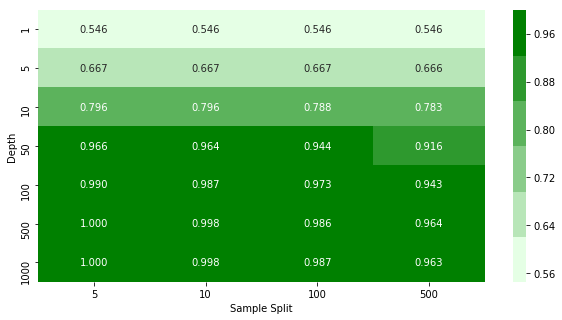

------------------------------ AUC Score for CV data ------------------------------


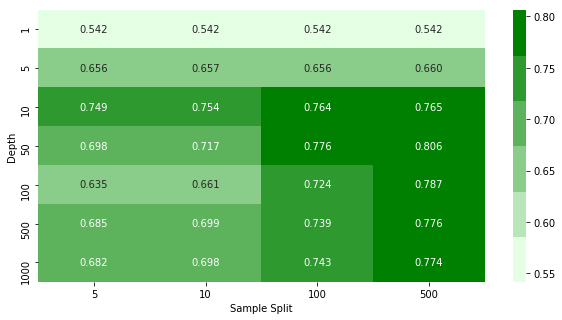

In [24]:
# find optimal depth and optimal split
DT_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

### Testing on Test data and Training in BoW

AUC Score for train data 0.7884031598026815
AUC Score for test data 0.762951328686464
macro f1 score for train data : 0.6472661388251876
macro f1 score for test data : 0.6229277045588568
micro f1 score for train data: 0.8654314720812183
micro f1 score for test data: 0.8584202168059104
hamming loss for train data: 0.13456852791878174
hamming loss for test data: 0.14157978319408962
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.80      0.24      0.37      6472
           1       0.87      0.99      0.92     32928

   micro avg       0.87      0.87      0.87     39400
   macro avg       0.83      0.61      0.65     39400
weighted avg       0.86      0.87      0.83     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.69      0.21      0.32      4649
           1       0.87      0.98      0.92     24317

   micro avg       0.86      0.86      0.86  

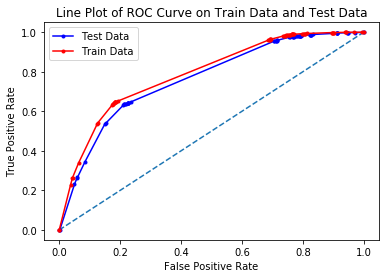

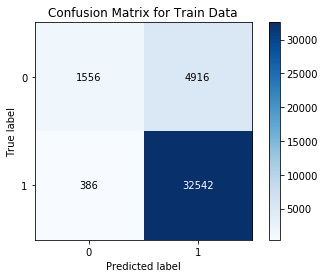

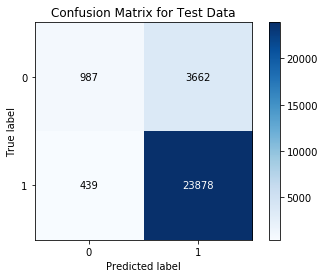

In [50]:
# optimal_depth and optima_split
testing(bow_train,Y_tr,bow_test,Y_test,optimal_depth=10,optimal_split=100)

In [51]:
clf = DecisionTreeClassifier(max_depth = 10, min_samples_split = 100)
clf.fit(bow_train,Y_tr)
imp_feature(count_vect,clf)

feature_importances	features
0.1690			disappoint     
0.1090			great          
0.0993			return         
0.0821			worst          
0.0670			wast           
0.0651			bad            
0.0621			love           
0.0539			best           
0.0482			delici         
0.0344			good           
0.0182			thought        
0.0166			money          
0.0145			aw             
0.0140			tast           
0.0092			batch          
0.0083			earth          
0.0077			perfect        
0.0077			easi           
0.0073			unfortun       
0.0072			terribl        


###  Visualize decision tree with Graphviz on BoW 

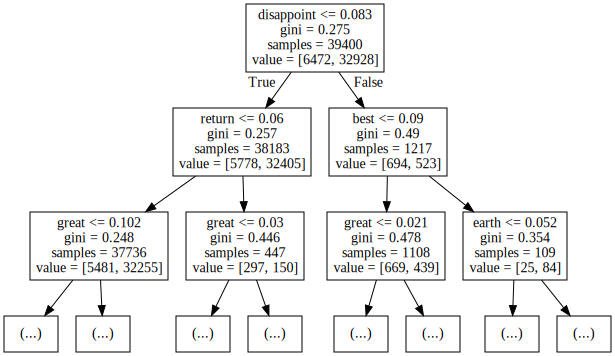

In [52]:
from sklearn import tree
from graphviz import Source
import graphviz
feat = count_vect.get_feature_names() 
Source(tree.export_graphviz(clf, out_file = None, feature_names = feat,max_depth=2))

##  TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (39400, 642970)
CV Data Size:  (19407, 642970)
Test Data Size:  (28966, 642970)


In [26]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(tfidf_train)
bow_cv = normalizer.transform(tfidf_cv)
bow_test = normalizer.transform(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (39400, 642970)
CV Data Size:  (19407, 642970)
Test Data Size:  (28966, 642970)


------------------------------ AUC Score for train data ------------------------------


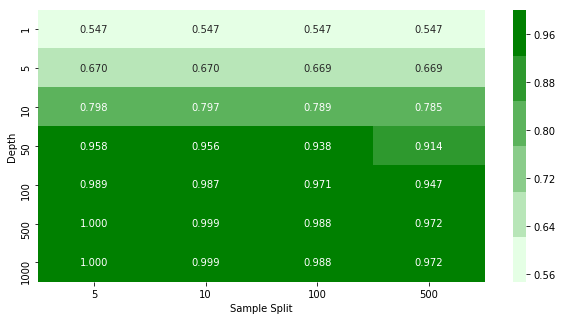

------------------------------ AUC Score for CV data ------------------------------


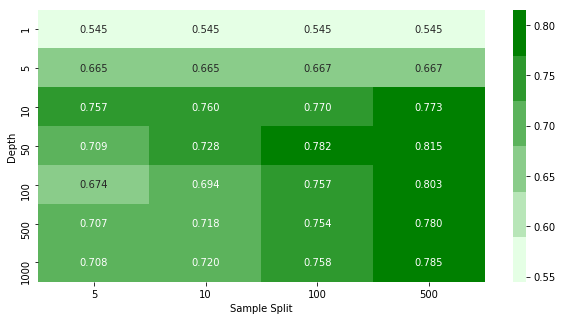

In [27]:
# find optimal depth and optimal split
DT_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### Testing on Test data and Traing data in TF-IDF

AUC Score for train data 0.7834226759196528
AUC Score for test data 0.7666180290757519
macro f1 score for train data : 0.6425005439317398
macro f1 score for test data : 0.6352311937429376
micro f1 score for train data: 0.8583502538071066
micro f1 score for test data: 0.85610716011876
hamming loss for train data: 0.1416497461928934
hamming loss for test data: 0.14389283988124008
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.69      0.25      0.36      6472
           1       0.87      0.98      0.92     32928

   micro avg       0.86      0.86      0.86     39400
   macro avg       0.78      0.61      0.64     39400
weighted avg       0.84      0.86      0.83     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.64      0.24      0.35      4649
           1       0.87      0.97      0.92     24317

   micro avg       0.86      0.86      0.86    

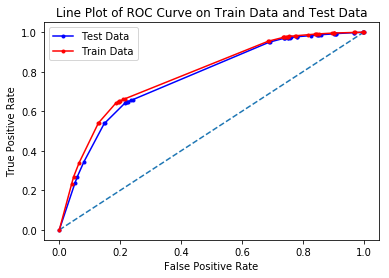

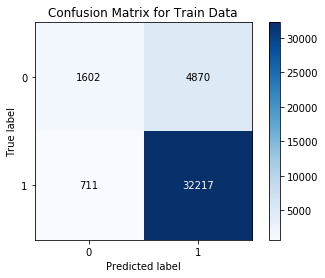

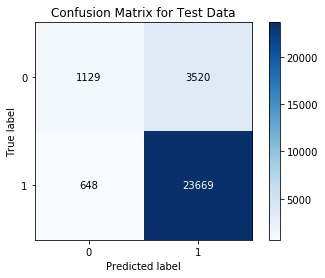

In [56]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_depth=10,optimal_split=500)

In [39]:
clf = DecisionTreeClassifier(max_depth =10 , min_samples_split =500 )
clf.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf)

feature_importances	features
0.1873			disappoint     
0.1097			return         
0.1096			great          
0.0882			worst          
0.0747			wast           
0.0705			bad            
0.0655			love           
0.0482			delici         
0.0431			good           
0.0413			best           
0.0272			wont disappoint
0.0110			aw             
0.0109			perfect        
0.0108			tast           
0.0100			thought        
0.0081			batch          
0.0078			terribl        
0.0069			made china     
0.0066			littl          
0.0064			unfortun       


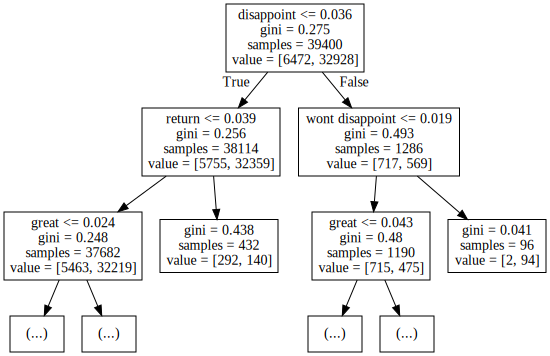

In [40]:
from sklearn import tree
from graphviz import Source
import graphviz
feat = tf_idf_vect.get_feature_names() 
Source(tree.export_graphviz(clf, out_file = None, feature_names = feat,max_depth=2))

## Avg W2V

In [28]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [29]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [30]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [31]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [32]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [33]:
train_avgw2v = avg_w2v(list_of_sent_train)

39400
50


In [34]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

19407
50


In [35]:
test_avgw2v = avg_w2v(list_of_sent_test)

28966
50


In [36]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

------------------------------ AUC Score for train data ------------------------------


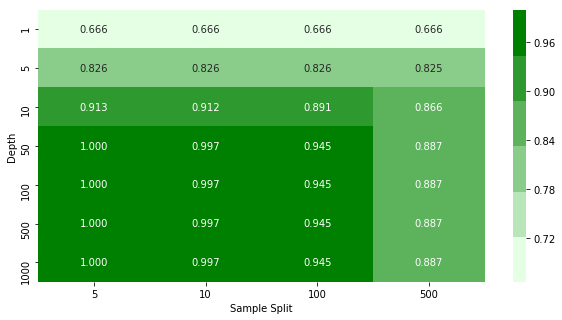

------------------------------ AUC Score for CV data ------------------------------


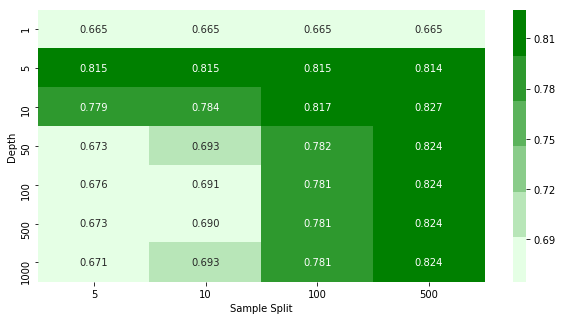

In [37]:
# find optimal depth and optimal split
DT_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

### Testing on Test data and Traing data in Avg-W2V 

AUC Score for train data 0.8253844694939163
AUC Score for test data 0.8087795660693864
macro f1 score for train data : 0.7043349857015415
macro f1 score for test data : 0.6854411716324752
micro f1 score for train data: 0.8632233502538071
micro f1 score for test data: 0.8572464268452669
hamming loss for train data: 0.13677664974619289
hamming loss for test data: 0.14275357315473314
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.63      0.40      0.49      6472
           1       0.89      0.96      0.92     32928

   micro avg       0.86      0.86      0.86     39400
   macro avg       0.76      0.68      0.70     39400
weighted avg       0.85      0.86      0.85     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.59      0.37      0.45      4649
           1       0.89      0.95      0.92     24317

   micro avg       0.86      0.86      0.86 

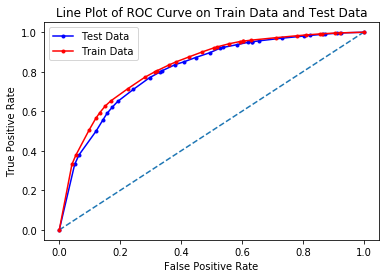

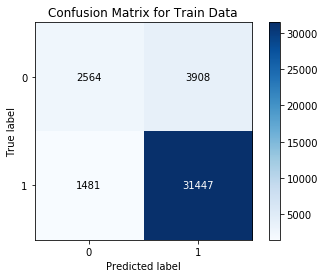

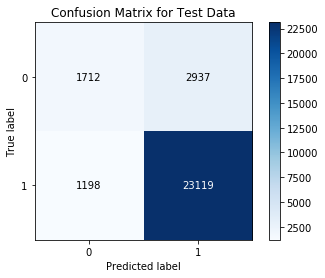

In [53]:
testing(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_depth=5,optimal_split=500)

## TF-IDF Weighted W2V

In [38]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (39400, 23389)
CV Data Size:  (19407, 23389)
Test Data Size:  (28966, 23389)


In [39]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

39400
50


In [40]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

19407
50


In [41]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

28966
50


In [42]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [43]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

------------------------------ AUC Score for train data ------------------------------


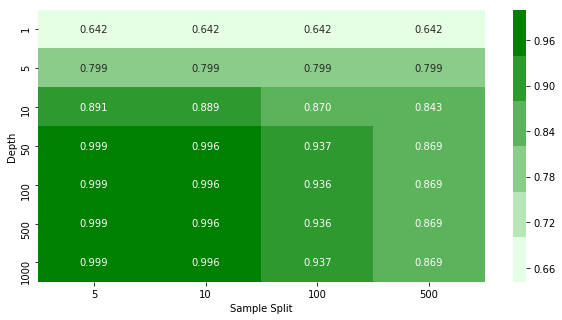

------------------------------ AUC Score for CV data ------------------------------


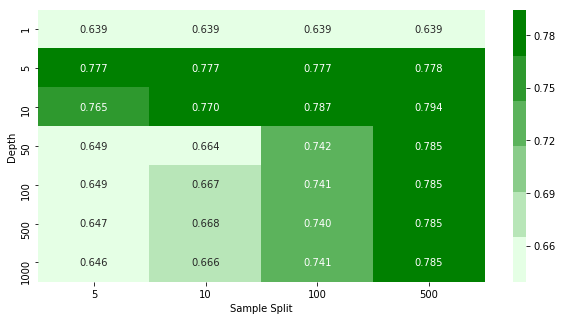

In [44]:
# find optimal depth and optimal split
DT_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

### Testing on Test data and Training data in TF-IDF W2V 

AUC Score for train data 0.7992453836613667
AUC Score for test data 0.7808073328222721
macro f1 score for train data : 0.633283634678326
macro f1 score for test data : 0.6292360102275922
micro f1 score for train data: 0.8520304568527919
micro f1 score for test data: 0.8540012428364289
hamming loss for train data: 0.14796954314720812
hamming loss for test data: 0.14599875716357108
Precision recall report for train data:
               precision    recall  f1-score   support

           0       0.63      0.24      0.35      6472
           1       0.87      0.97      0.92     32928

   micro avg       0.85      0.85      0.85     39400
   macro avg       0.75      0.61      0.63     39400
weighted avg       0.83      0.85      0.82     39400

Precision recall report for test data:
               precision    recall  f1-score   support

           0       0.62      0.23      0.34      4649
           1       0.87      0.97      0.92     24317

   micro avg       0.85      0.85      0.85  

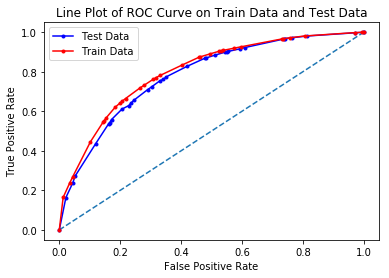

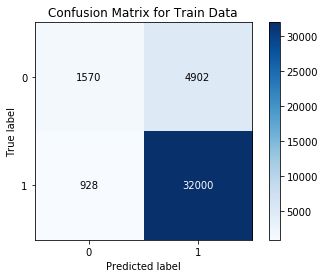

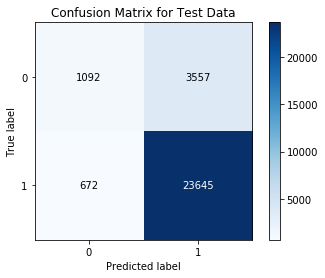

In [54]:
testing(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_depth=5,optimal_split=100)

In [57]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer","Best Hyper Parameter(Depth)","Best Hyper parameter(min_split)","Test Auc Score"]
x.add_row(["BoW",10,100,76.37])
x.add_row(["Tf-Idf",10,500,76.66])
x.add_row(["Avg-W2V",5,500,80.18])
x.add_row(["TfIdf-W2V",5,100,78.08])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+-----------------------------+---------------------------------+----------------+
| Vectorizer | Best Hyper Parameter(Depth) | Best Hyper parameter(min_split) | Test Auc Score |
+------------+-----------------------------+---------------------------------+----------------+
|    BoW     |              10             |               100               |     76.37      |
|   Tf-Idf   |              10             |               500               |     76.66      |
|  Avg-W2V   |              5              |               500               |     80.18      |
| TfIdf-W2V  |              5              |               100               |     78.08      |
+------------+-----------------------------+---------------------------------+----------------+
